# KATS GM-RNN

Learn how to make a forecast on the NOAA sample dataset with the pretrained GM-RNN model from Kats. 

## Step One: 
Import Dependencies

In [1]:
# !pip install influxdb-client==1.30.0
# !pip install kats

In [51]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from influxdb_client import InfluxDBClient
from influxdb_client.client.write_api import SYNCHRONOUS
from kats.consts import TimeSeriesData

from kats.models.sarima import SARIMAModel, SARIMAParams
import kats.utils.time_series_parameter_tuning as tpt
from kats.consts import ModelEnum, SearchMethodEnum, TimeSeriesData
from kats.models.arima import ARIMAParams, ARIMAModel
from kats.models.globalmodel.ensemble import GMEnsemble, load_gmensemble_from_file

from ax.core.parameter import ChoiceParameter, FixedParameter, ParameterType
from ax.models.random.sobol import SobolGenerator
from ax.models.random.uniform import UniformGenerator
warnings.simplefilter(action='ignore')

In [52]:
# !curl https://influx-testdata.s3.amazonaws.com/noaa.csv -o noaa.csv

### prepare data in influxdb

import "experimental/csv"

relativeToNow = (tables=<-) => tables
    |> elapsed()
    |> sort(columns: ["_time"], desc: true)
    |> cumulativeSum(columns: ["elapsed"])
    |> map(fn: (r) => ({r with _time: time(v: int(v: now()) - r.elapsed * 10000000000)})) #note here there is an extra "0"

csv.from(url: "https://influx-testdata.s3.amazonaws.com/noaa.csv")
    |> relativeToNow()
    |> limit(n:1000, offset: 0)    
    |> to(bucket: "test_bucket_from_python")

## Step Two:
Instantiate the Python Client Libary and build the Flux query. 


In [53]:
client = InfluxDBClient(url="https://us-west-2-1.aws.cloud2.influxdata.com/", token="ZFSDx1udluHMpx3cshN73iZPXoCA5NXIfuHlIspzD6u33WjKdWTbgrny3rKKORebc3y5qSZdiaTOiyB-VejfQw==", org="03dd0439a8172000")
write_api = client.write_api(write_options=SYNCHRONOUS)
query_api = client.query_api()

In [54]:
df = query_api.query_data_frame('from(bucket: "test_bucket_from_python")'
  '|> range(start: -30d)'
  '|> filter(fn: (r) => r["_measurement"] == "average_temperature")'
  '|> filter(fn: (r) => r["_field"] == "degrees")'
  '|> filter(fn: (r) => r["location"] == "coyote_creek")'
  '|> aggregateWindow(every: 1d, fn: mean, createEmpty: false)'
  '|> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")'
  '|> keep(columns:["_time","degrees"])')

In [55]:
df = df.copy()
df = df.drop(columns=['result', 'table'])
df = df.rename(columns={"_time": "time"})
df["time"] = df["time"].apply(lambda x: x.strftime('%Y-%m-%d'))
df

,time,degrees
0,2022-09-02,80.052632
1,2022-09-03,78.916667
2,2022-09-04,79.833333
3,2022-09-05,77.625000
4,2022-09-06,81.208333
5,2022-09-07,80.791667
6,2022-09-08,79.416667
7,2022-09-09,80.250000
8,2022-09-10,79.083333
9,2022-09-11,81.458333


In [56]:
df_plot = df.set_index('time')

<AxesSubplot:xlabel='time'>

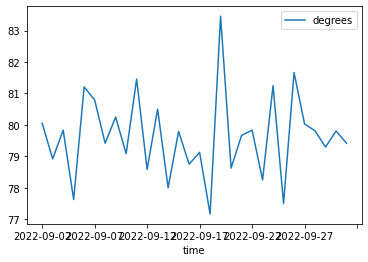

In [57]:
df_plot.plot()

## Step Three: 
Reformat timestamp.

In [59]:
gme_rnn = load_gmensemble_from_file("models/pretrained_daily_rnn.p")

for i in range(15):

    df_t = df.head(i+15)
    train = df_t.head(i+12)
    test = df_t.tail(3).reset_index(drop=True)
    df_ts = TimeSeriesData(train)
    fcsts = gme_rnn.predict(df_ts, steps = 3)
    fcsts_df = list(fcsts.items())[0][1]
    fcsts_df = fcsts_df.join(test["degrees"])
    fcsts_df = fcsts_df[['fcst_quantile_0.5', 'degrees', 'time']]
    fcsts_df['location'] = "coyote_creek"
    print(i)
    print(fcsts_df)
    write_api.write(bucket="test_bucket_from_python",
               record=fcsts_df,
               data_frame_measurement_name="forecast",
               data_frame_tag_columns=["location"],
               data_frame_timestamp_column="time")

0
   fcst_quantile_0.5    degrees       time      location
0          80.496109  78.000000 2022-09-14  coyote_creek
1          79.221916  79.791667 2022-09-15  coyote_creek
2          79.872696  78.750000 2022-09-16  coyote_creek
1
   fcst_quantile_0.5    degrees       time      location
0          77.220421  79.791667 2022-09-15  coyote_creek
1          77.909760  78.750000 2022-09-16  coyote_creek
2          76.767418  79.125000 2022-09-17  coyote_creek
2
   fcst_quantile_0.5    degrees       time      location
0          79.920662  78.750000 2022-09-16  coyote_creek
1          78.835693  79.125000 2022-09-17  coyote_creek
2          79.899971  77.166667 2022-09-18  coyote_creek
3
   fcst_quantile_0.5    degrees       time      location
0          77.883240  79.125000 2022-09-17  coyote_creek
1          78.982361  77.166667 2022-09-18  coyote_creek
2          76.674347  83.458333 2022-09-19  coyote_creek
4
   fcst_quantile_0.5    degrees       time      location
0          79.938461 

## Step Six:
Write data with the client library. 

In [66]:
dff = query_api.query_data_frame('from(bucket: "test_bucket_from_python")'
  '|> range(start: -30d)'
  '|> filter(fn: (r) => r["_measurement"] == "forecast")'
  '|> filter(fn: (r) => r["_field"] == "fcst_quantile_0.5")'
  '|> filter(fn: (r) => r["location"] == "coyote_creek")'
  '|> aggregateWindow(every: 1d, fn: mean, createEmpty: false)'
  '|> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")'
  '|> keep(columns:["_time","fcst_quantile_0.5"])')
dff = dff.copy()
dff = dff.drop(columns=['result', 'table'])
dff = dff.rename(columns={"_time": "time"})
dff.head(30)

,time,fcst_quantile_0.5
0,2022-09-14 00:00:00+00:00,82.338249
1,2022-09-15 00:00:00+00:00,80.496109
2,2022-09-16 00:00:00+00:00,77.220421
3,2022-09-17 00:00:00+00:00,79.920662
4,2022-09-18 00:00:00+00:00,77.883240
5,2022-09-19 00:00:00+00:00,79.938461
6,2022-09-20 00:00:00+00:00,75.499985
7,2022-09-21 00:00:00+00:00,85.541473
8,2022-09-22 00:00:00+00:00,79.623276
9,2022-09-23 00:00:00+00:00,78.647354


In [67]:
dfm = query_api.query_data_frame('from(bucket: "test_bucket_from_python")'
  '|> range(start: -30d)'
  '|> filter(fn: (r) => r["_measurement"] == "average_temperature")'
  '|> filter(fn: (r) => r["_field"] == "degrees")'
  '|> filter(fn: (r) => r["location"] == "coyote_creek")'
  '|> aggregateWindow(every: 1d, fn: mean, createEmpty: false)'
  '|> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")'
  '|> keep(columns:["_time","degrees"])')
dfm = dfm.copy()
dfm = dfm.drop(columns=['result', 'table'])
dfm = dfm.rename(columns={"_time": "time"})
dfm.head(30)

,time,degrees
0,2022-09-02 00:00:00+00:00,80.052632
1,2022-09-03 00:00:00+00:00,78.916667
2,2022-09-04 00:00:00+00:00,79.833333
3,2022-09-05 00:00:00+00:00,77.625000
4,2022-09-06 00:00:00+00:00,81.208333
5,2022-09-07 00:00:00+00:00,80.791667
6,2022-09-08 00:00:00+00:00,79.416667
7,2022-09-09 00:00:00+00:00,80.250000
8,2022-09-10 00:00:00+00:00,79.083333
9,2022-09-11 00:00:00+00:00,81.458333


In [68]:
df = pd.concat([dff, dfm], axis=1, join="inner")
df.head(30)

,time,fcst_quantile_0.5,time,degrees
0,2022-09-14 00:00:00+00:00,82.338249,2022-09-02 00:00:00+00:00,80.052632
1,2022-09-15 00:00:00+00:00,80.496109,2022-09-03 00:00:00+00:00,78.916667
2,2022-09-16 00:00:00+00:00,77.220421,2022-09-04 00:00:00+00:00,79.833333
3,2022-09-17 00:00:00+00:00,79.920662,2022-09-05 00:00:00+00:00,77.625000
4,2022-09-18 00:00:00+00:00,77.883240,2022-09-06 00:00:00+00:00,81.208333
5,2022-09-19 00:00:00+00:00,79.938461,2022-09-07 00:00:00+00:00,80.791667
6,2022-09-20 00:00:00+00:00,75.499985,2022-09-08 00:00:00+00:00,79.416667
7,2022-09-21 00:00:00+00:00,85.541473,2022-09-09 00:00:00+00:00,80.250000
8,2022-09-22 00:00:00+00:00,79.623276,2022-09-10 00:00:00+00:00,79.083333
9,2022-09-23 00:00:00+00:00,78.647354,2022-09-11 00:00:00+00:00,81.458333


<AxesSubplot:xlabel='time'>

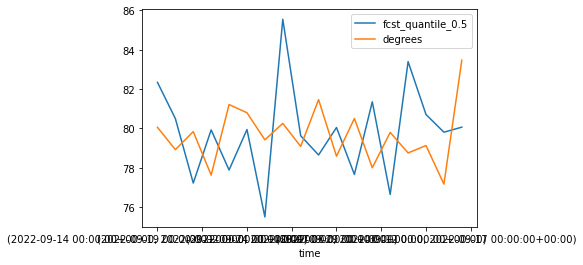

In [69]:
df_plot = df.set_index('time')
df_plot.plot()

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
### Write dataframe to bucket with data_frame_tag_columns=["location"]

In [111]:
data = {'temperature': [10, 11, 12], 
         'time': pd.to_datetime(["2022-09-25", "2022-09-26", "2022-09-27"]), 
         'location': ["coyote_creek", "coyote_creek", "coyote_creek"]}

In [112]:
df=pd.DataFrame(data)
df

,temperature,time,location
0,10,2022-09-25,coyote_creek
1,11,2022-09-26,coyote_creek
2,12,2022-09-27,coyote_creek


In [113]:
write_api.write(bucket="test_bucket_from_python",
               record=df,
               data_frame_measurement_name="test",
               data_frame_tag_columns=["location"],
               data_frame_timestamp_column="time")

In [114]:
df = query_api.query_data_frame('from(bucket: "test_bucket_from_python")'
  '|> range(start: -6d)'
  '|> filter(fn: (r) => r["_measurement"] == "test")'
  '|> filter(fn: (r) => r["_field"] == "temperature")'
  '|> filter(fn: (r) => r["location"] == "coyote_creek")'
  '|> aggregateWindow(every: 1d, fn: mean, createEmpty: false)'
  '|> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")'
  '|> keep(columns:["_time","temperature", "location"])')
df = df.copy()
df = df.drop(columns=['result', 'table'])
df = df.rename(columns={"_time": "time"})
df.head()

,time,location,temperature
0,2022-09-26 00:00:00+00:00,coyote_creek,10.0
1,2022-09-27 00:00:00+00:00,coyote_creek,11.0
2,2022-09-28 00:00:00+00:00,coyote_creek,12.0
3,2022-09-29 00:00:00+00:00,coyote_creek,10.0
4,2022-09-30 00:00:00+00:00,coyote_creek,11.0
